In [1]:
import warnings

warnings.filterwarnings("ignore")

import math

import torch
from torch import nn, distributions, utils

import matplotlib.pyplot as plt

In [2]:
class InverseGamma(distributions.TransformedDistribution):
    def __init__(self, concentration, rate):
        super().__init__(
            distributions.Gamma(concentration, rate),
            distributions.PowerTransform(-1.0),
            validate_args=True,
        )

In [3]:
class NIGNLL(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, targets, gamma, v, alpha, beta):
        Gamma = 2 * beta * (1 + v)
        nll = (
            0.5 * torch.log(math.pi / v)
            - alpha * Gamma.log()
            + (alpha + 0.5) * torch.log(Gamma + v * (targets - gamma) ** 2)
            + torch.lgamma(alpha)
            - torch.lgamma(alpha + 0.5)
        )
        return nll.mean()


class NIGReg(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, targets, gamma, v, alpha, beta):
        reg = torch.norm(targets - gamma, 1, dim=1, keepdim=True) * (2 * v + alpha)
        return reg.mean()

In [4]:
class NIGLoss(nn.Module):
    def __init__(self, reg_weight: float) -> None:
        super().__init__()
        self.reg_weight = reg_weight
        self._nig_reg = NIGReg()
        self._nig_nll = NIGNLL()

    def forward(self, inputs, targets):
        if inputs.size(-1) != 4:
            raise ValueError(
                "The output of the network have to be equal to four. "
                f"Got {inputs.size(-1)}."
            )

        gamma, v, alpha, beta = inputs.split(1, dim=-1)
        v = nn.functional.softplus(v)
        alpha = 1 + nn.functional.softplus(alpha)
        beta = nn.functional.softplus(beta)

        loss_nll = self._nig_nll(targets, gamma, v, alpha, beta)
        loss_reg = self._nig_reg(targets, gamma, v, alpha, beta)
        return loss_nll + self.reg_weight * loss_reg

In [5]:
class DummyNet(nn.Module):
    def __init__(self, input_dim, compress_dim, output_dim) -> None:
        super().__init__()
        net = []
        dim = input_dim
        for item in compress_dim:
            net += [nn.Linear(dim, item), nn.ReLU()]
            dim = item
        net += [nn.Linear(dim, output_dim)]
        self.net = nn.Sequential(*net)

    def forward(self, x):
        return self.net(x)


net = DummyNet(1, (10, 5), 4)
net

DummyNet(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=4, bias=True)
  )
)

In [6]:
def train_epoch(model, optimizer, loader, reg_weight, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    loss_fn = NIGLoss(reg_weight=reg_weight)

    for x, y in loader:
        optimizer.zero_grad()
        x = x.to(device=device)
        y = y.to(device=device)
        logits = model(x)
        if y.ndim == 1:
            y = y.unsqueeze(1)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
    return model, optimizer, loss.item()


def train(loader, max_epochs, reg_weight, log_interval=None):
    model = DummyNet(1, (64, 64), 4)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
    for i in range(1, max_epochs + 1):
        model, optimizer, loss = train_epoch(model, optimizer, loader, reg_weight)
        if not i % log_interval and log_interval is not None:
            print(f"epoch: {i}/{max_epochs} loss: {loss:.3f}")
    print("training finished.")
    return model

In [7]:
def make_toy_dataset(num_samples):
    x = torch.linspace(-4.0, 4.0, num_samples).unsqueeze(1)
    y = x**3 + torch.normal(0.0, 3.0, size=x.size())
    return utils.data.TensorDataset(x, y)


def make_loader(num_samples, **kwargs):
    dataset = make_toy_dataset(num_samples)
    loader = utils.data.DataLoader(dataset, **kwargs)
    return loader

In [8]:
reg_weight = 5e-3

loader = make_loader(num_samples=1000, batch_size=100)
model = train(loader, max_epochs=500, reg_weight=reg_weight, log_interval=100)

epoch: 100/500 loss: 3.119
epoch: 200/500 loss: 2.712
epoch: 300/500 loss: 3.203
epoch: 400/500 loss: 2.844
epoch: 500/500 loss: 3.170
training finished.


In [9]:
with torch.no_grad():
    x = torch.linspace(-7, 7, 1000).unsqueeze(1)
    y = x**3
    gamma, v, alpha, beta = model(x).split(1, dim=1)
    v = nn.functional.softplus(v)
    alpha = 1 + nn.functional.softplus(alpha)
    beta = nn.functional.softplus(beta)

    var = torch.sqrt(beta / (v * (alpha - 1)))
    mean = gamma.squeeze(1)
    var.squeeze_(1)
    x.squeeze_(1)

Text(0.5, 1.0, '$\\lambda=5\\times10^{-3}$')

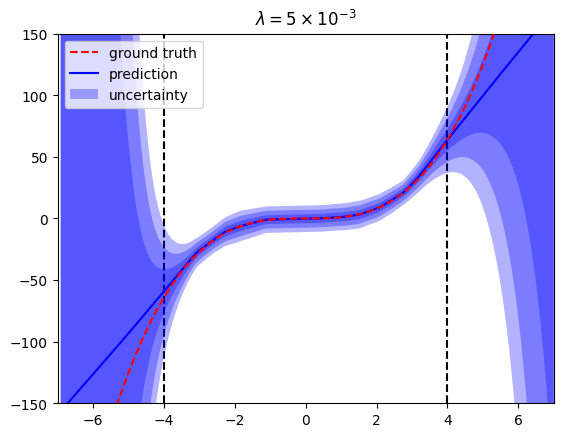

In [10]:
fig, ax = plt.subplots(1, 1)
ax.axvline(zorder=0, x=-4.0, c="k", linestyle="--")
ax.axvline(zorder=0, x=4.0, c="k", linestyle="--")
ax.plot(x, y, zorder=3, c="r", linestyle="--", label="ground truth")
ax.plot(x, mean, label="prediction", zorder=2, c="b")

for k in torch.linspace(0, 4, 4):
    ax.fill_between(
        x,
        mean - k * var,
        mean + k * var,
        linewidth=0,
        alpha=0.3,
        edgecolor=None,
        facecolor="blue",
        label="uncertainty" if not k else None,
    )
plt.gca().set_ylim(-150, 150)
plt.gca().set_xlim(-7, 7)
plt.legend(loc="upper left")
plt.title(r"$\lambda=5\times10^{-3}$")

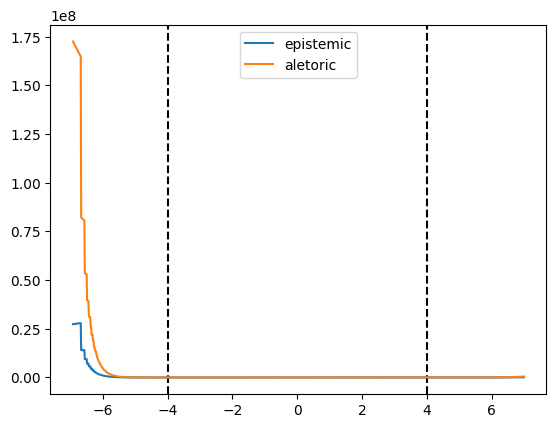

In [11]:
epistemic_uncertainty = beta / (v * (alpha - 1))
aleatoric_uncertainty = beta / (alpha - 1)

fig, ax = plt.subplots(1, 1)
ax.axvline(zorder=0, x=-4.0, c="k", linestyle="--")
ax.axvline(zorder=0, x=4.0, c="k", linestyle="--")
ax.plot(x, epistemic_uncertainty, label="epistemic")
ax.plot(x, aleatoric_uncertainty, label="aletoric")
plt.legend()